In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import glob
from PIL import Image
import tensorflow as tf
import cv2
from tf_explain.core.grad_cam import GradCAM
import os
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
from skimage import transform
import skimage
import os
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

c:\Users\maxme\anaconda3\envs\tf_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [3]:
# Enable memory growth for the GPU
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [4]:
# Allocate more memory for the GPU as needed
#config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth = True
#sess = tf.compat.v1.Session(config=config)

In [5]:
# dont use gpu
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## 1) The Dataset

- Assuming you have a classification problem, is it binary, multi-class or multi-label?
  - This is a multi-class classification problem.

- How many classes?
  - There are 6 classes in the dataset, which are Cheetah, Fox, Hyena, Lion, Tiger, and Wolf.

- How many images per class?
  - The number of images per class are: Cheetah (610), Fox (550), Hyena (605), Lion (600), Tiger (572), and Wolf (563). The total number of images in the dataset is 3,500.

- Train/Test sizes
  - The train/test split is 80% train and 20% test. After the split, the train set contains 2,800 images, and the test set contains 700 images. Before the split, both the train and test sets contain 3,500 images.

- Image size?
  - The images in the dataset have a size of 128 x 128 pixels.

- How are the images labeled?
  - The images are labeled based on the name of the animal they represent.

- Dataset source(s)?
  - The dataset is a combination of three sources: Imsitu dataset, DuckDuckGo images, and a Kaggle dataset.

In [6]:
# Creating list of X and y
X_train_3500 = []
y_train_3500 = []
# Iterate the folder with glob
for fpath in glob.glob(r'C:\Users\maxme\OneDrive\Bureaublad\wild_life_images_3500\*.jpg'):
    # Opening images with Pillow
    im = Image.open(fpath)
    im_resized = im.resize((128, 128))
    # Get label from file path
    if 'cheetah' in fpath:
        label = 0
    elif 'fox' in fpath:
        label = 1
    elif 'hyena' in fpath:
        label = 2
    elif 'lion' in fpath:
        label = 3
    elif 'tiger' in fpath:
        label = 4
    elif 'wolf' in fpath:
        label = 5
    # Put image array to X
    # Put label to y
    X_train_3500.append(np.array(im_resized))
    y_train_3500.append(label)
# Convert the list of arrays
# Into a numpy array
X_train_3500 = np.array(X_train_3500)
y_train_3500 = np.array(y_train_3500)

### Examples of images in the dataset

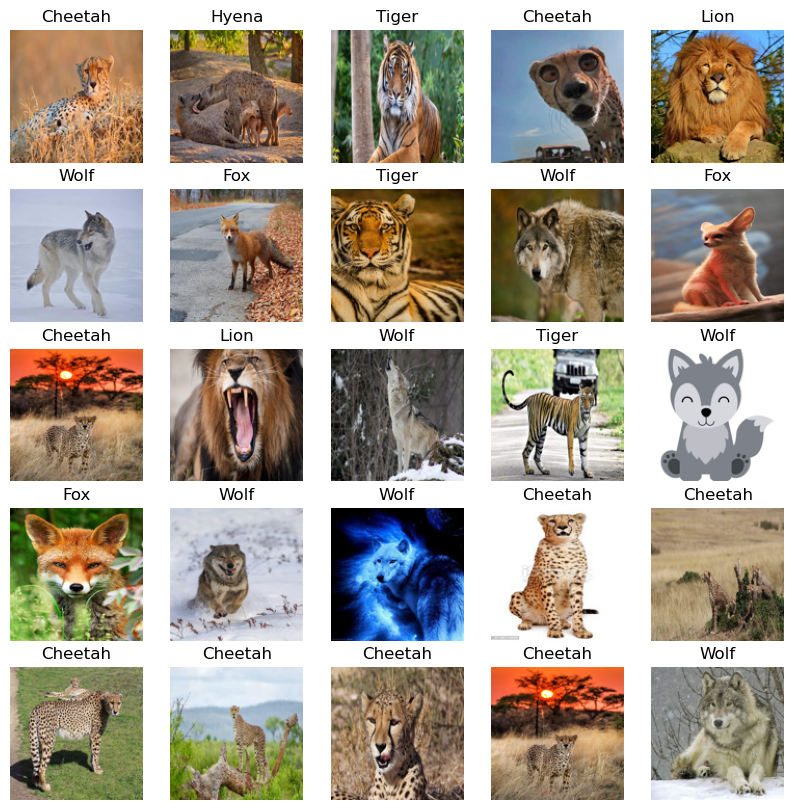

In [7]:
label_map = {0: 'Cheetah', 1: 'Fox', 2: 'Hyena', 3: 'Lion', 4: 'Tiger', 5: 'Wolf'}

fig, axs = plt.subplots(5, 5, figsize=(10,10))
for i, ax in enumerate(axs.flat):
    index = random.randint(0, len(X_train_3500)-1)
    label = y_train_3500[index]
    ax.imshow(X_train_3500[index])
    ax.set_title(label_map[label])
    ax.axis('off')
plt.show()

### How many classes and how many images per class?

In [8]:
print('I have', np.count_nonzero(y_train_3500 == 0), 'images of' , label_map[0] + 's',
      '\n''I have', np.count_nonzero(y_train_3500 == 1), 'images of' , label_map[1] + 'es',
      '\n''I have', np.count_nonzero(y_train_3500 == 2), 'images of' , label_map[2] + 's',
      '\n''I have', np.count_nonzero(y_train_3500 == 3), 'images of' , label_map[3] + 's',
      '\n''I have', np.count_nonzero(y_train_3500 == 4), 'images of' , label_map[4] + 's',
      '\n''I have', np.count_nonzero(y_train_3500 == 5), 'images of' , label_map[5] + 's',
)

I have 610 images of Cheetahs 
I have 550 images of Foxes 
I have 605 images of Hyenas 
I have 600 images of Lions 
I have 572 images of Tigers 
I have 563 images of Wolfs


I have 6 different classes


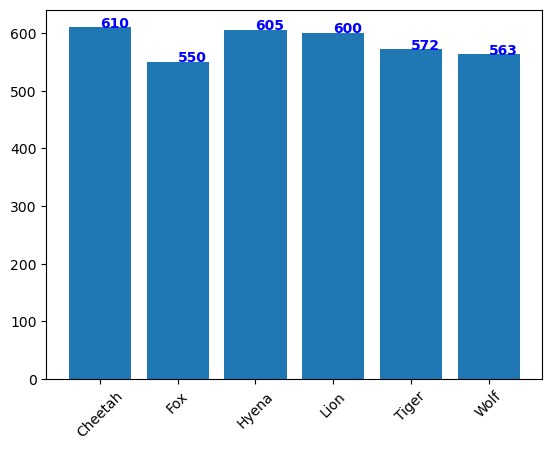

In [9]:
print('I have', len(np.unique(y_train_3500)), 'different classes')

# Make a bar plot of the number of images per class.
plt.bar(label_map.values(), np.bincount(y_train_3500))
plt.xticks(rotation=45)

#Add annotations to the bars
for i, v in enumerate(np.bincount(y_train_3500)):
    plt.text(i, v, str(v), color='blue', fontweight='bold')
    
plt.show()

## 2) Baselines

- Random guess accuracy?
  - Since I have 6 classes, the random guess accuracy is 1/6 = 16.67%

- Human-Level Performance accuracy?
  - A total of 20 people were asked to classify the images. The average score was 98.5%.
  - [HLP](https://github.com/BredaUniversityADSAI/2022-23c-1fcmgt-reg-ai-01-MaxMeiners/blob/main/Assignments/HLP%20Wildlife(1-20).xlsx)

- Multilayer Perceptron accuracy?
  - Both MLP's have an accuracy of around 56.7%.
  - [MLP](https://github.com/BredaUniversityADSAI/2022-23c-1fcmgt-reg-ai-01-MaxMeiners/blob/main/Deliverables/W2-DL1-MLP-Student-Notebook.ipynb)
  - [MLP with visualizations of learning curves, training and validation loss, and training and validation accuracy](https://github.com/BredaUniversityADSAI/2022-23c-1fcmgt-reg-ai-01-MaxMeiners/blob/main/Deliverables/W2-DL2-MLP-Student-Notebook.ipynb)

## 3) Preprocessing

Explain all the preprocessing steps you did.

### The size of my images

In [10]:
print(X_train_3500.shape) # Size of the dataset
print("As you can see, I have", str(y_train_3500.shape), "images of wild life animals, which are in", str(np.array(im_resized).shape), "pixels.")

(3500, 128, 128, 3)
As you can see, I have (3500,) images of wild life animals, which are in (128, 128, 3) pixels.


In [11]:
# Splitting the dataset into train and test sets
X_train_3500, X_test_3500, y_train_3500, y_test_3500 = train_test_split(X_train_3500, y_train_3500, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [12]:
print(X_train_3500.shape,
        X_test_3500.shape)

(2800, 128, 128, 3) (700, 128, 128, 3)


In [13]:
# Splitting the dataset into train and validation sets
X_val_3500, X_test_3500, y_val_3500, y_test_3500 = train_test_split(X_test_3500, y_test_3500, 
                                                    test_size=0.5, 
                                                    random_state=42)

In [14]:
print(X_train_3500.shape,
      X_val_3500.shape,
      X_test_3500.shape)

(2800, 128, 128, 3) (350, 128, 128, 3) (350, 128, 128, 3)


In [15]:
# Dividing the values by 255 to normalize the data and have values between 0 and 1
X_train_3500 = X_train_3500/255
X_val_3500 = X_val_3500/255
X_test_3500 = X_test_3500/255

### Data augmentation

In [16]:
datagen = ImageDataGenerator(rotation_range=30,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             zoom_range=0.2)

data_generator = datagen.flow(X_train_3500, y_train_3500, batch_size=32)

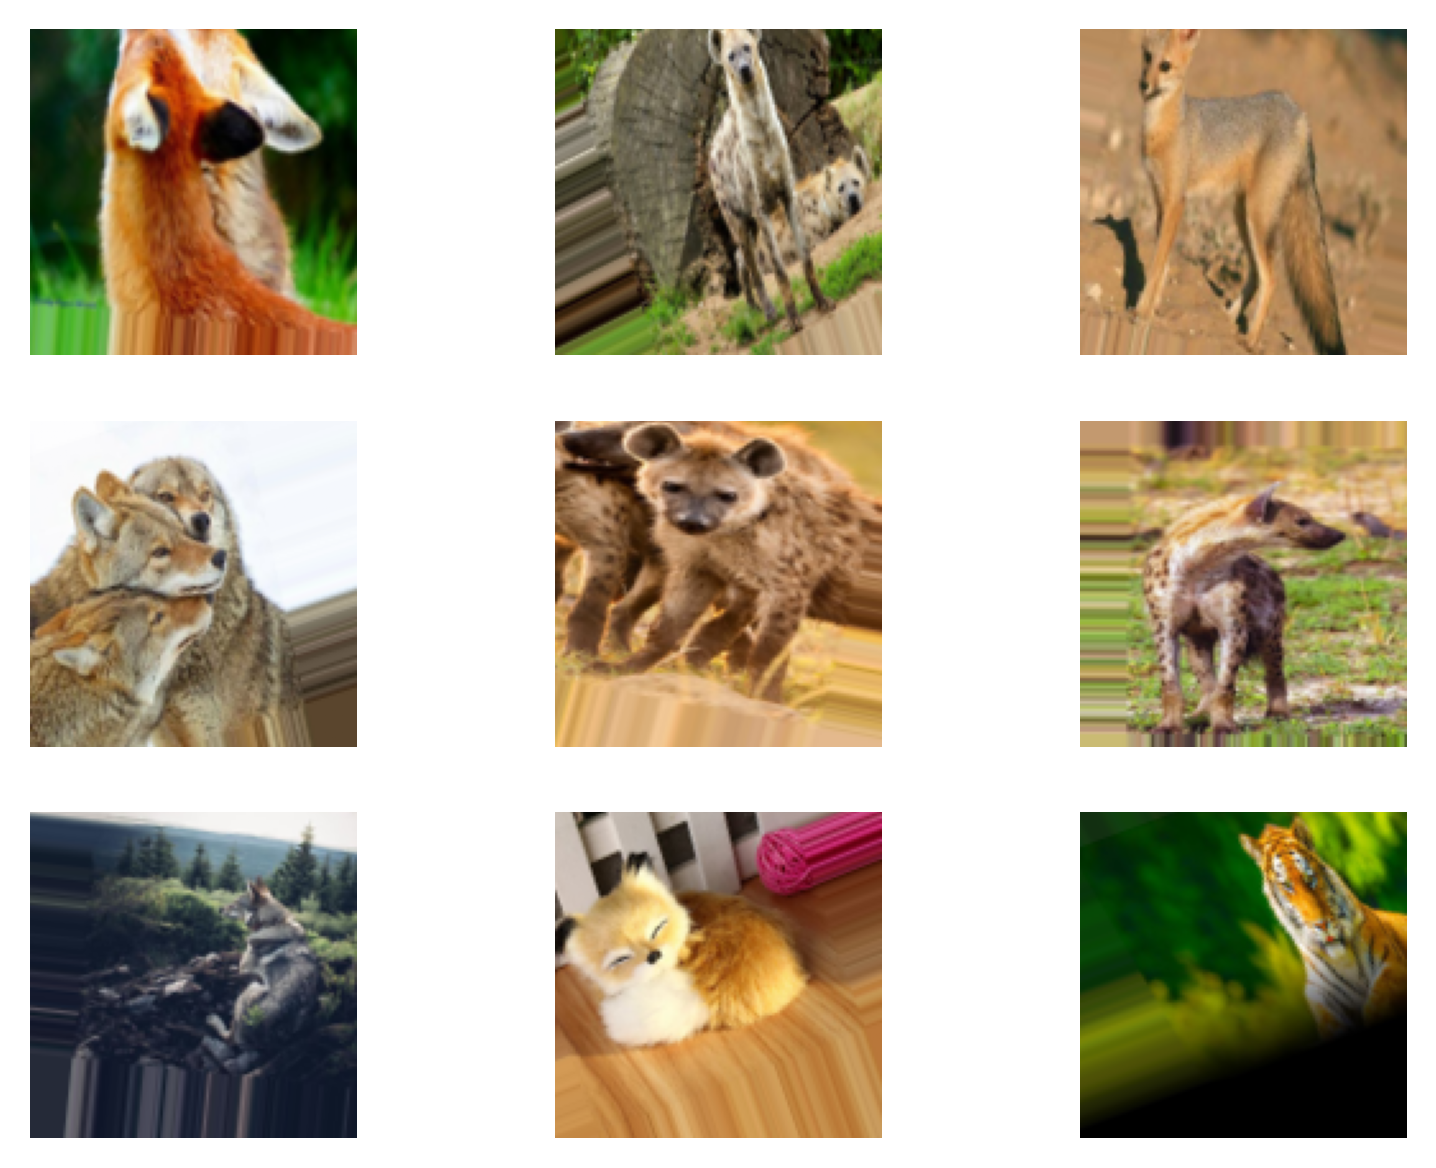

In [17]:
f, ax = plt.subplots(3, 3, dpi=300)

counter = 0
for batch in datagen.flow(X_train_3500, batch_size=1):
    i = int((counter-counter%3)/3)
    j = counter%3
    
    ax[i, j].imshow(batch[0], cmap='gray')
    ax[i, j].axis('off')
    
    counter += 1
    if counter==9:break

## 4) CNN architecture

In [18]:
def build_model(print_summary=False):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', activation = 'relu', input_shape=(128, 128, 3)))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same', activation = 'relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), padding='same', activation = 'relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    # model.add(BatchNormalization())
    # model.add(Dropout(0.5))
    model.add(Dense(128, activation = 'relu'))
    # model.add(BatchNormalization())
    # model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))

    if print_summary:
        model.summary()
    return model

model = build_model(print_summary=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       2

## 5) CNN training

- Loss function

- Optimizer (with its hyper-parameters)

- Metrics

- Learning curves

In [19]:
# Compiling the model
def compile_model(model, learning_rate):
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = compile_model(model, learning_rate=0.001)

In [20]:
# Early stopping callback
early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

In [21]:
#Fitting the model
H = model.fit(data_generator, 
              epochs=100, 
              validation_data=(X_val_3500, y_val_3500),
              callbacks=early_stop)

Epoch 1/100
88/88 [==============================] - 26s 181ms/step - loss: 1.7972 - accuracy: 0.1918 - val_loss: 1.8315 - val_accuracy: 0.1714
Epoch 2/100
88/88 [==============================] - 11s 121ms/step - loss: 1.6323 - accuracy: 0.2939 - val_loss: 1.8591 - val_accuracy: 0.3257
Epoch 3/100
88/88 [==============================] - 11s 130ms/step - loss: 1.4751 - accuracy: 0.4182 - val_loss: 1.6038 - val_accuracy: 0.4029
Epoch 4/100
88/88 [==============================] - 15s 175ms/step - loss: 1.4120 - accuracy: 0.4382 - val_loss: 1.2610 - val_accuracy: 0.5086
Epoch 5/100
88/88 [==============================] - 15s 168ms/step - loss: 1.3449 - accuracy: 0.4761 - val_loss: 1.3468 - val_accuracy: 0.4857
Epoch 6/100
88/88 [==============================] - 15s 172ms/step - loss: 1.2786 - accuracy: 0.5096 - val_loss: 1.5274 - val_accuracy: 0.4571
Epoch 7/100
88/88 [==============================] - 14s 152ms/step - loss: 1.2267 - accuracy: 0.5196 - val_loss: 1.1739 - val_accuracy:

In [22]:
val_loss, val_acc = model.evaluate(X_test_3500, y_test_3500)
print('Validation loss:', val_loss,
      '\n''Validation accuracy:', val_acc)

11/11 [==============================] - 0s 9ms/step - loss: 0.6293 - accuracy: 0.7857
Validation loss: 0.6292905211448669 
Validation accuracy: 0.7857142686843872


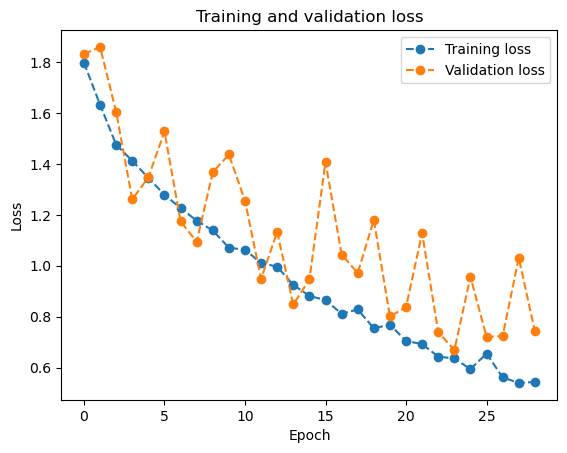

In [23]:
def loss_plotter(H):
    plt.plot(H.history['loss'], label='Training loss', linestyle='--', marker='o')
    plt.plot(H.history['val_loss'], label='Validation loss', linestyle='--',  marker='o')
    plt.title('Training and validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

loss_plotter(H)

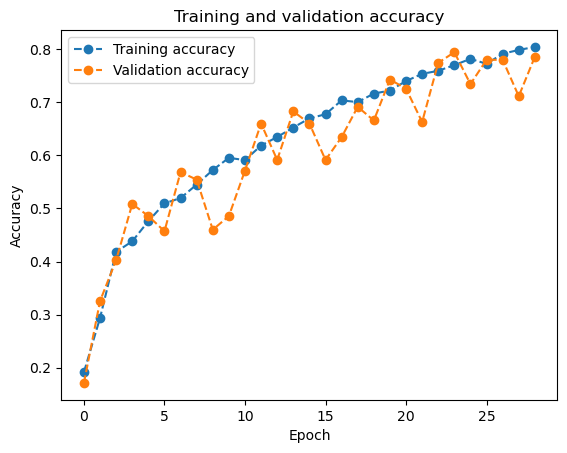

In [24]:
def accuracy_plotter(H):
    plt.plot(H.history['accuracy'], label='Training accuracy', linestyle='--', marker='o')
    plt.plot(H.history['val_accuracy'], label='Validation accuracy', linestyle='--',  marker='o')
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

accuracy_plotter(H)

In [25]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

In [26]:
histories = []
best_val_losses = []

for lr in learning_rates:
    print('Training with:', lr)
    model = build_model()
    model = compile_model(model, learning_rate=lr)
    
    H = model.fit(X_train_3500, y_train_3500, 
                  epochs=100, 
                  batch_size=32, 
                  validation_data=(X_val_3500, y_val_3500),
                  callbacks=early_stop)
    
    best_loss = min(H.history['val_loss'])

    best_val_losses.append(best_loss)
    histories.append(H)

Training with: 0.01
Epoch 1/100
88/88 [==============================] - 3s 23ms/step - loss: 1.7771 - accuracy: 0.2021 - val_loss: 1.7281 - val_accuracy: 0.2286
Epoch 2/100
88/88 [==============================] - 2s 28ms/step - loss: 1.6243 - accuracy: 0.3200 - val_loss: 1.5441 - val_accuracy: 0.3486
Epoch 3/100
88/88 [==============================] - 2s 22ms/step - loss: 1.3910 - accuracy: 0.4393 - val_loss: 1.3057 - val_accuracy: 0.5114
Epoch 4/100
88/88 [==============================] - 1s 16ms/step - loss: 1.2250 - accuracy: 0.5400 - val_loss: 1.2317 - val_accuracy: 0.5457
Epoch 5/100
88/88 [==============================] - 1s 16ms/step - loss: 1.0734 - accuracy: 0.5932 - val_loss: 1.0729 - val_accuracy: 0.5771
Epoch 6/100
88/88 [==============================] - 1s 15ms/step - loss: 0.8895 - accuracy: 0.6721 - val_loss: 1.0041 - val_accuracy: 0.6314
Epoch 7/100
88/88 [==============================] - 1s 16ms/step - loss: 0.6992 - accuracy: 0.7425 - val_loss: 0.9798 - val_acc

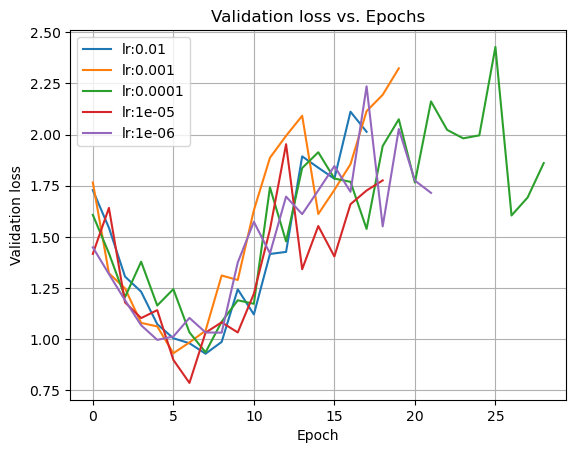

In [27]:
for i, lr in enumerate(learning_rates):
    plt.plot(histories[i].history['val_loss'], label='lr:'+str(lr))
plt.title('Validation loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.grid()
plt.legend()
plt.show()

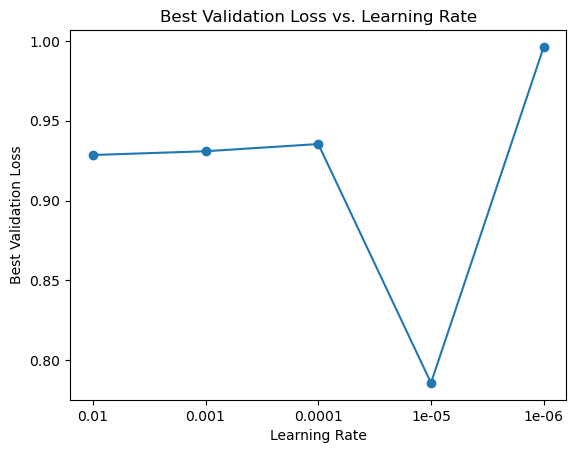

In [28]:
plt.plot(range(len(learning_rates)), best_val_losses, 'o-')
plt.xticks(range(len(learning_rates)), learning_rates)
plt.title('Best Validation Loss vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Best Validation Loss')
plt.show()

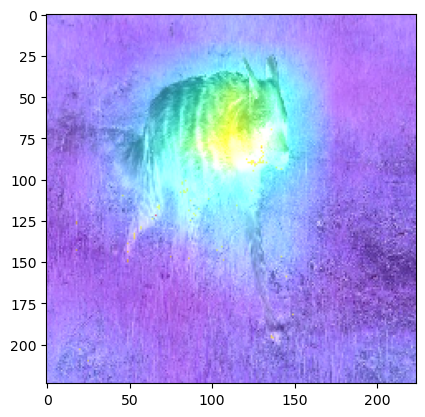

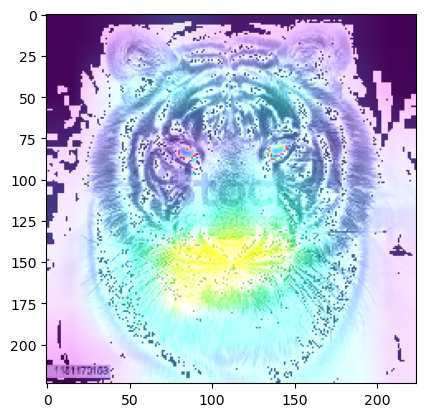

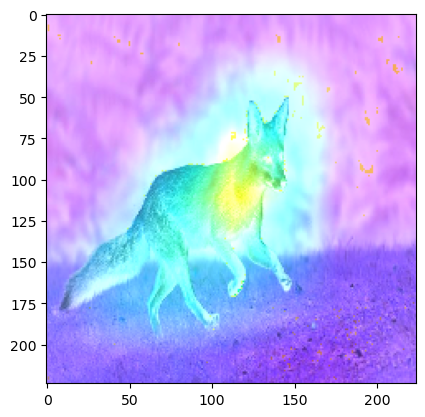

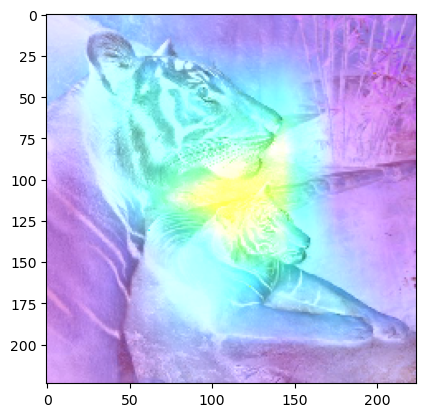

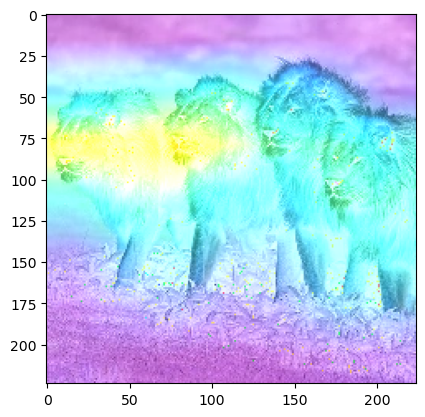

In [29]:
# Set the path to the folder containing the images
IMAGE_FOLDER_PATH = r"C:/Users/maxme/OneDrive/Bureaublad/wild_life_images_3500/"

# Define the number of images you want to visualize
NUM_IMAGES = 5

# Load the model
model_gradcam = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=True)

# Initialize the explainer as an instance of the GradCAM object
explainer = GradCAM()

# Loop through the folder and randomly select NUM_IMAGES images
for i in range(NUM_IMAGES):
    # Get a random image from the folder
    image_name = random.choice(os.listdir(IMAGE_FOLDER_PATH))
    image_path = os.path.join(IMAGE_FOLDER_PATH, image_name)

    # Load the image and preprocess it
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Create the input in a format that the explainer expects (a tuple)
    input_img = (np.array([img]), None)

    # Obtain explanations for your image using VGG 16 and GradCAM
    class_index = 281
    grid = explainer.explain(input_img, model_gradcam, class_index=class_index)

    # Save the resulting image
    output_path = os.path.join(r"C:\Users\maxme\OneDrive\Bureaublad\grad_cam", f"grad_cam_{image_name}")
    explainer.save(grid, r"C:\Users\maxme\OneDrive\Bureaublad\grad_cam", output_path)

    # Plot the resulting image
    plt.imshow(grid)
    plt.show()

100%|██████████| 1000/1000 [00:15<00:00, 63.41it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


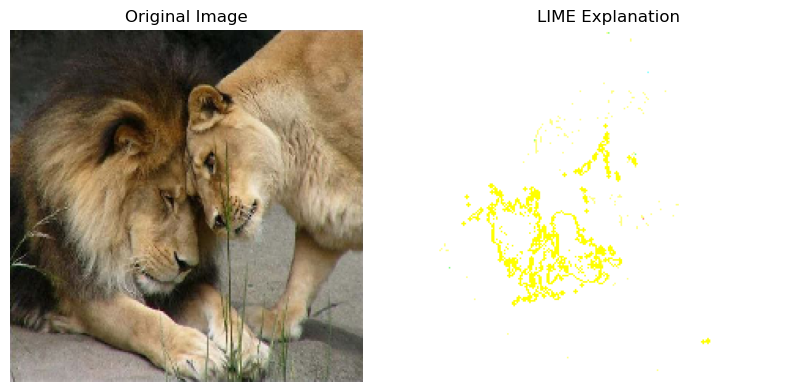

In [30]:
explainer = lime_image.LimeImageExplainer()

# Define a function that takes an input image and returns the predicted class probabilities
def predict_fn(images):
    return model_gradcam.predict(images)

#load an image
image_folder = r'C:/Users/maxme/OneDrive/Bureaublad/wild_life_images_3500/'

# Get a list of all the image file names in the folder
image_files = os.listdir(image_folder)

# Choose a random image file from the list
random_image_file = random.choice(image_files)

# Load the image and convert it to a numpy array
image_path = os.path.join(image_folder, random_image_file)
original_image = load_img(image_path, target_size=(224, 224))
original_image_array = img_to_array(original_image)

# Generate an explanation using LIME
explanation = explainer.explain_instance(original_image_array, predict_fn, top_labels=5, hide_color=0, num_samples=1000)

# Visualize the explanation
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(original_image)
ax[0].set_title('Original Image')
ax[0].axis('off')
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
ax[1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
ax[1].set_title('LIME Explanation')
ax[1].axis('off')
plt.show()

## 6) Model performance

Metrics plots

### Confusion matrix

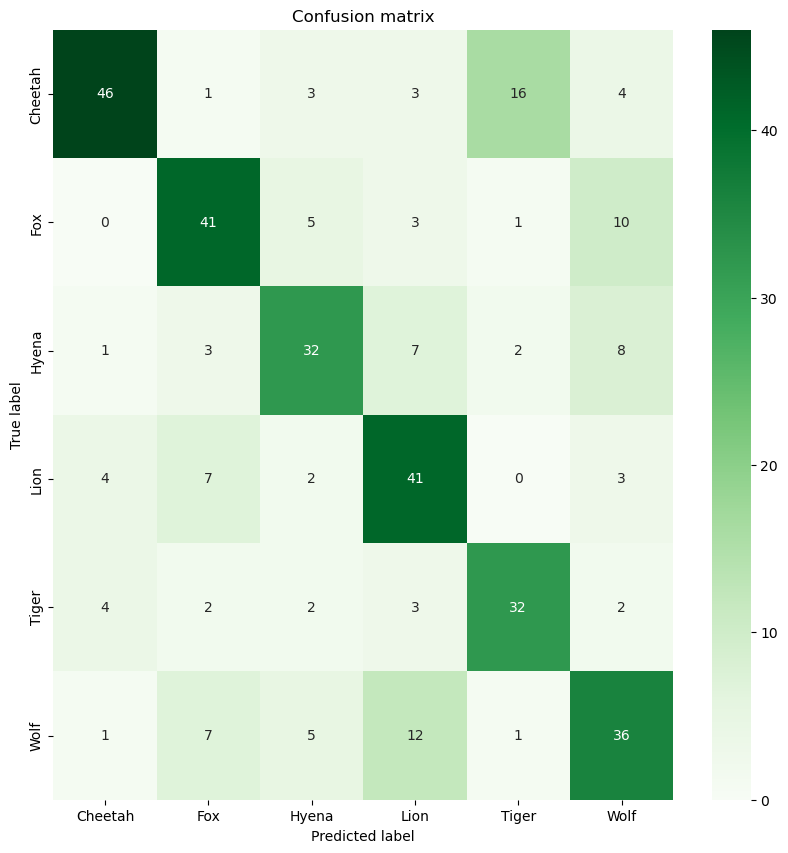

In [31]:
# Store true labels in y_true and predictions in y_pred in order to generate the confusion matrix
y_true = y_test_3500
y_pred_prob = model.predict(X_test_3500)
y_pred = np.argmax(y_pred_prob, axis=1)

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the classes
classes = ['Cheetah', 'Fox', 'Hyena', 'Lion', 'Tiger', 'Wolf']

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [32]:
print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

     Cheetah       0.82      0.63      0.71        73
         Fox       0.67      0.68      0.68        60
       Hyena       0.65      0.60      0.63        53
        Lion       0.59      0.72      0.65        57
       Tiger       0.62      0.71      0.66        45
        Wolf       0.57      0.58      0.58        62

    accuracy                           0.65       350
   macro avg       0.65      0.65      0.65       350
weighted avg       0.66      0.65      0.65       350



## 7) Error analysis

Top error interpretation

### Top error interpretation

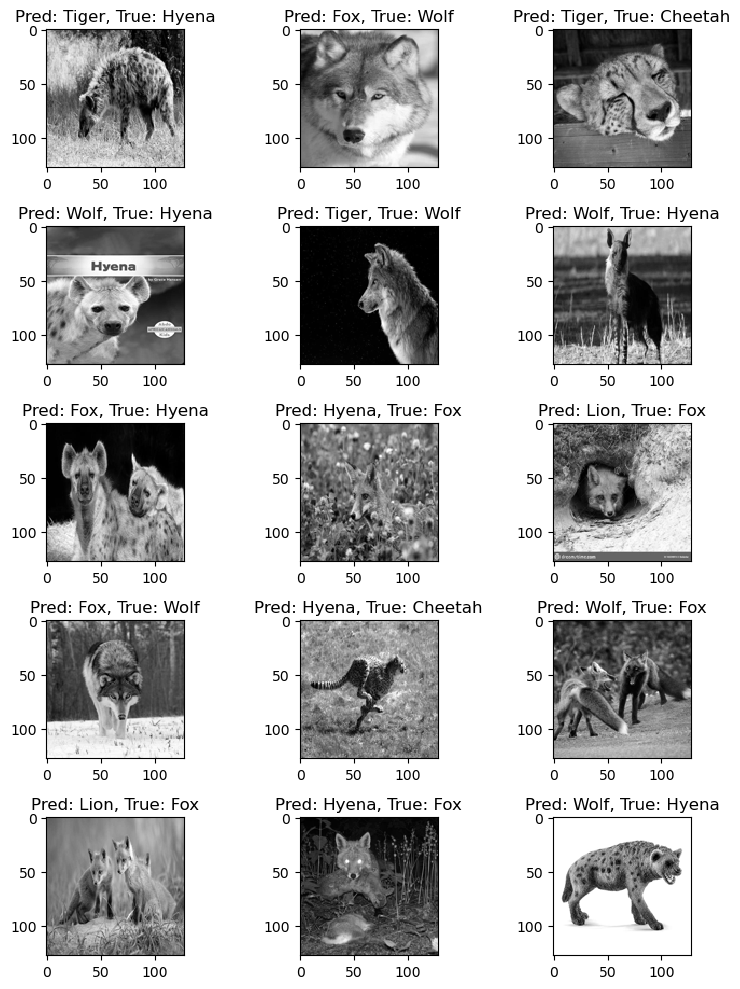

Top misclassified probabilities:
[[[4.98450734e-03 3.46653883e-06 4.03206359e-05 3.13737996e-06
   1.99154094e-02 9.75053072e-01]
  [6.95598744e-12 7.06305059e-08 5.15966065e-07 2.35048336e-08
   1.30300082e-09 9.99999404e-01]
  [1.44107681e-09 9.95832264e-01 3.37761747e-07 1.85882491e-05
   1.89923171e-08 4.14886139e-03]
  [9.82245430e-02 1.03967315e-04 8.24433193e-03 3.32233161e-01
   5.25742412e-01 3.54515947e-02]
  [1.09480366e-01 2.59036906e-02 3.46154660e-01 2.85981577e-02
   4.71169144e-01 1.86939649e-02]
  [2.61112427e-06 1.16282899e-05 3.34932281e-07 4.47700774e-12
   9.80645597e-01 1.93398464e-02]]

 [[1.09480366e-01 2.59036906e-02 3.46154660e-01 2.85981577e-02
   4.71169144e-01 1.86939649e-02]
  [4.98450734e-03 3.46653883e-06 4.03206359e-05 3.13737996e-06
   1.99154094e-02 9.75053072e-01]
  [1.44107681e-09 9.95832264e-01 3.37761747e-07 1.85882491e-05
   1.89923171e-08 4.14886139e-03]
  [2.61112427e-06 1.16282899e-05 3.34932281e-07 4.47700774e-12
   9.80645597e-01 1.93398464e

In [33]:
# Define class labels
class_labels = ['Cheetah', 'Fox', 'Hyena', 'Lion', 'Tiger', 'Wolf']

# Get the indices of the misclassified samples
misclassified_indices = np.where(y_pred != y_true)[0]
misclassified_probabilities = y_pred_prob[misclassified_indices]
top_misclassified_indices = np.argsort(misclassified_probabilities)[::-1][:15]

# Set the size of the figure and subplots
plt.figure(figsize=(8, 10))

# Generate and plot the misclassified samples
for i, misclassified_index in enumerate(misclassified_indices[:15]):
    plt.subplot(5, 3, i+1)
    misclassified_image = X_test_3500[misclassified_index]
    resized_image = skimage.transform.resize(misclassified_image, (128, 128, 3), anti_aliasing=True, mode='reflect')
    resized_image = skimage.color.rgb2gray(resized_image)
    plt.imshow(resized_image, cmap='gray', interpolation='none')
    predicted_class = class_labels[y_pred[misclassified_index]]
    true_class = class_labels[y_true[misclassified_index]]
    plt.title(f"Pred: {predicted_class}, True: {true_class}")
plt.tight_layout()
plt.show()

# Print the top misclassified probabilities
print("Top misclassified probabilities:")
print(misclassified_probabilities[top_misclassified_indices])